## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import os

import seaborn as sns
import torch
import torch.nn as nn
import torchsummary
import torchvision
import torchvision.transforms as transforms

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print("Directory", path, "is created!")
    else:
        print("Directory", path, "already exists!")


root_path = "fmnist"
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))

fmnist_dataset_train = torchvision.datasets.FashionMNIST(
    root_path,
    train=True,
    transform=train_transform,
    target_transform=None,
    download=download,
)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(
    root_path,
    train=False,
    transform=test_transform,
    target_transform=None,
    download=download,
)

In [4]:
train_loader = torch.utils.data.DataLoader(
    fmnist_dataset_train, batch_size=128, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    fmnist_dataset_test, batch_size=256, shuffle=False, num_workers=2
)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
len(fmnist_dataset_train)

60000

In [7]:
for img, label in train_loader:
    print(img.shape)
    #     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [8]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes),
        )

    def forward(self, inp):
        return self.model(inp)

In [9]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


Your experiments come here:

In [10]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

In [11]:
def train(dataloader,
          model,
          loss_fn,
          optimizer,
          loss_hist=None,
          epoch_current_size=None):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            if not loss_hist is None and not epoch_current_size is None:
                loss_hist.append(loss)
                epoch_current_size.append(current)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [12]:
def test(dataloader, model, loss_fn, accuracy=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    if not accuracy is None:
        accuracy.append(correct)
    print(
        f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

In [55]:
import matplotlib.pyplot as plt

epochs = 20
loss_hist = []
current_size = []
accuracy = []
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    epoch_current_size = []
    train(train_loader, model, loss_fn, opt, loss_hist, epoch_current_size)
    current_size.extend([t * current for current in epoch_current_size])
    test(test_loader, model, loss_fn, accuracy)
print("Done!")

Epoch 1
-------------------------------
loss: 2.410207  [  128/60000]
loss: 1.224836  [12928/60000]
loss: 0.938796  [25728/60000]
loss: 0.790873  [38528/60000]
loss: 0.789725  [51328/60000]
Test Error: 
 Accuracy: 75.5%, Avg loss: 0.724102 

Epoch 2
-------------------------------
loss: 0.694323  [  128/60000]
loss: 0.659719  [12928/60000]
loss: 0.630578  [25728/60000]
loss: 0.663586  [38528/60000]
loss: 0.567544  [51328/60000]
Test Error: 
 Accuracy: 79.6%, Avg loss: 0.614570 

Epoch 3
-------------------------------
loss: 0.553883  [  128/60000]
loss: 0.594950  [12928/60000]
loss: 0.644687  [25728/60000]
loss: 0.576316  [38528/60000]
loss: 0.564391  [51328/60000]
Test Error: 
 Accuracy: 81.2%, Avg loss: 0.565865 

Epoch 4
-------------------------------
loss: 0.506432  [  128/60000]
loss: 0.657433  [12928/60000]
loss: 0.505161  [25728/60000]
loss: 0.454374  [38528/60000]
loss: 0.562221  [51328/60000]
Test Error: 
 Accuracy: 81.7%, Avg loss: 0.543968 

Epoch 5
------------------------

Text(0.5, 1.0, 'train loss')

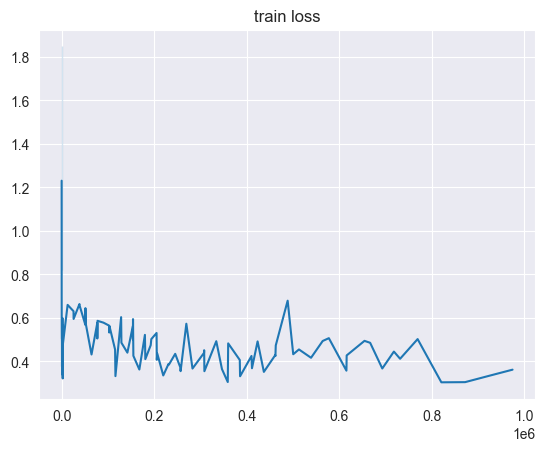

In [56]:
ax = sns.lineplot(x=current_size, y=loss_hist)
ax.set_title("train loss")

<Axes: >

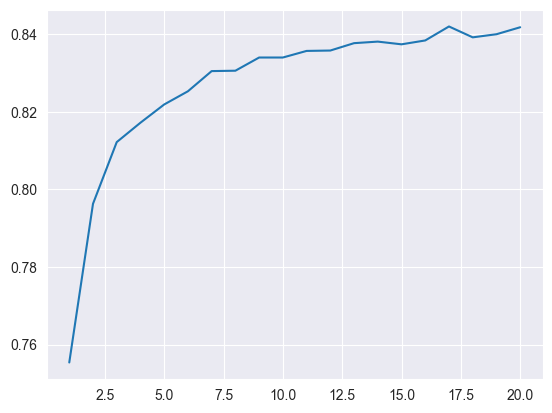

In [57]:
sns.lineplot(x=range(1, epochs+1), y=accuracy)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [17]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 10 * input_shape),
            nn.BatchNorm1d(num_features=10 * input_shape),
            nn.ReLU(),
            nn.Linear(10 * input_shape, 10 * input_shape),
            nn.BatchNorm1d(num_features=10 * input_shape),
            nn.ReLU(),
            nn.Linear(10 * input_shape, 10 * input_shape),
            nn.BatchNorm1d(num_features=10 * input_shape),
            nn.ReLU(),
            nn.Linear(10 * input_shape, num_classes),
        )

    def forward(self, inp):
        return self.model(inp)

In [18]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 7840]       6,154,400
       BatchNorm1d-3                 [-1, 7840]          15,680
              ReLU-4                 [-1, 7840]               0
            Linear-5                 [-1, 7840]      61,473,440
       BatchNorm1d-6                 [-1, 7840]          15,680
              ReLU-7                 [-1, 7840]               0
            Linear-8                 [-1, 7840]      61,473,440
       BatchNorm1d-9                 [-1, 7840]          15,680
             ReLU-10                 [-1, 7840]               0
           Linear-11                   [-1, 10]          78,410
Total params: 129,226,730
Trainable params: 129,226,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00


In [19]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

# Your experiments, come here

In [20]:
epochs = 20
loss_hist = []
current_size = []
accuracy = []
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    epoch_current_size = []
    train(test_loader, model, loss_fn, opt, loss_hist, 
          epoch_current_size)
    current_size.extend([t * current for current in epoch_current_size])
    test(train_loader, model, loss_fn, accuracy)
print("Done!")

Epoch 1
-------------------------------
loss: 2.277843  [  256/10000]
Test Error: 
 Accuracy: 83.6%, Avg loss: 0.448440 

Epoch 2
-------------------------------
loss: 0.405163  [  256/10000]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.426776 

Epoch 3
-------------------------------
loss: 0.311981  [  256/10000]
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.417014 

Epoch 4
-------------------------------
loss: 0.229055  [  256/10000]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.415991 

Epoch 5
-------------------------------
loss: 0.162302  [  256/10000]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.568491 

Epoch 6
-------------------------------
loss: 0.147811  [  256/10000]
Test Error: 
 Accuracy: 80.2%, Avg loss: 0.820400 

Epoch 7
-------------------------------
loss: 0.176646  [  256/10000]
Test Error: 
 Accuracy: 81.1%, Avg loss: 0.812528 

Epoch 8
-------------------------------
loss: 0.189825  [  256/10000]
Test Error: 
 Accuracy: 77.1%, Avg loss: 1.132115 

Epoch 9
----------------

Text(0.5, 1.0, 'train loss')

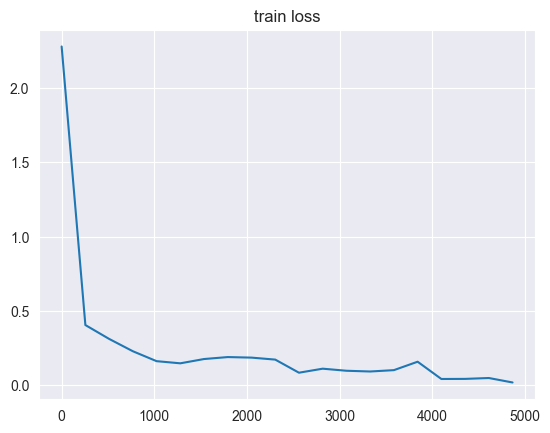

In [21]:
ax = sns.lineplot(x=current_size, y=loss_hist)
ax.set_title("train loss")

<Axes: >

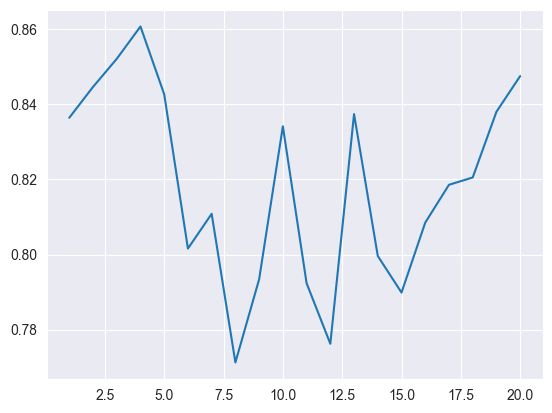

In [22]:
sns.lineplot(x=range(1, epochs+1), y=accuracy)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28 * 28,))

In [ ]:
model = FixedNeuralNetwork().to(device)
opt =  # YOUR CODE HERE
loss_func =  # YOUR CODE HERE

# Your experiments, come here

### Conclusions:
_Write down small report with your conclusions and your ideas._